In [1]:
import os
import numpy as np
import random
import torch
import torchvision
import torch.nn as nn
from sklearn.utils import resample
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
import glob
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim




seed = 20200220
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
# Generator object for DataLoader random batching
g_cpu = torch.Generator()
g_cpu.manual_seed(seed)
1
# Checking for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transformation = transforms.Compose([
        transforms.Resize((244,244)),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

# transform_norm = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
# ])



/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def validation_strat(n_samples = 100):

    train_img_concepts = np.arange(1654)
    img_per_concept = 10
    val_concepts = np.sort(resample(train_img_concepts, replace=False,
        n_samples=n_samples))
    idx_val = np.zeros((len(train_img_concepts)*img_per_concept), dtype=bool)
    for i in val_concepts:
        idx_val[i*img_per_concept:i*img_per_concept+img_per_concept] = True

    return idx_val

def limit_samples(idx_val, n_samples = 560):
    train_img_concepts = np.arange(1654)
    img_per_concept = 10
    val_concepts = np.sort(resample(train_img_concepts, replace=False,
        n_samples=n_samples))
    
    samples = np.zeros((len(train_img_concepts)*img_per_concept), dtype=bool)
    for i in val_concepts:
        if idx_val[i*img_per_concept:i*img_per_concept+img_per_concept].all() == True:
            pass
        else: 
            samples[i*img_per_concept:i*img_per_concept+img_per_concept] = True
    return samples

def all_idx(idx_val, limit_samples):
    
    train_img_concepts = np.arange(1654)
    img_per_concept = 10
    all_idx = np.zeros((len(train_img_concepts)*img_per_concept), dtype=bool)
    
    for (i, d) in enumerate(idx_val): 
        if d == True: 
            all_idx[i] = True
            
    for (i, d) in enumerate(limit_samples): 
        if d == True: 
            all_idx[i] = True
    
    return all_idx

def paths_to_npy(path, test_data = False):
    """
    :return: EEG Test paths, Training paths.
    """
    
    if test_data:
        return glob.glob(path + "/sub-**/*_test.npy", recursive=True)

    return glob.glob(path + "/sub-**/*_training.npy", recursive=True)

def paths_to_subjects(path = os.getcwd() + '/eeg_dataset' + '/preprocessed'):
    return glob.glob(path + "/sub-**", recursive = True)

idx_val = validation_strat()
limit_samples = limit_samples(idx_val)
all_idx = all_idx(idx_val, limit_samples)




In [3]:
def collate_images_dataset(idx_val, reduce = False, limit_samples = False, data_dir = '/eeg_dataset', transform = None):

    img_dirs = os.path.join(os.getcwd() + data_dir, 'images', 'training_images')

    image_paths = []
    for root, dirs, files in os.walk(img_dirs):
        for file in files:
            if file.endswith(".jpg"):
                image_paths.append(os.path.join(root,file))
                
    image_paths.sort()

    if reduce: 
        reduced = []
    train = []
    val = []
    for i, image in enumerate(tqdm(image_paths, desc = 'Training and validation images loading...')):
        if idx_val[i] == True:
            img = Image.open(image).convert('RGB')
            img = transformation(img)
            val.append(img)
        elif reduce:
            if limit_samples[i] == True: 
                img = Image.open(image).convert('RGB')
                img = transformation(img)
                reduced.append(img)
        else:
            img = Image.open(image).convert('RGB')
            img = transformation(img)
            train.append(img)

        


    img_dirs = os.path.join(os.getcwd() + data_dir, 'images', 'test_images')

    image_paths = []

    for root, dirs, files in os.walk(img_dirs):
        for file in files:
            if file.endswith(".jpg"):
                image_paths.append(os.path.join(root,file))

    image_paths.sort()
    test = []
    for image in tqdm(image_paths, desc = 'Test images loading...'):
        img = Image.open(image).convert('RGB')
        img = transformation(img)
        test.append(img)

    if reduce: 
        return reduced, val, test
    
    return train, val, test

def collate_participant_eeg(idx_val, reduce = False, limit_samples = False, all_idx = False, participant = None, data_path ='eeg_dataset/preprocessed', sub = '/sub-02', to_torch = False):

    if participant:
        train_file = np.load(participant + '/preprocessed_eeg_training.npy', allow_pickle = True).item()
        test_file = np.load(participant + '/preprocessed_eeg_test.npy', allow_pickle = True).item()
    else:
        train_file = np.load(data_path + sub + '/preprocessed_eeg_training.npy', allow_pickle = True).item()
        test_file = np.load(data_path + sub + '/preprocessed_eeg_test.npy', allow_pickle = True).item()

    print (data_path + sub + '/preprocessed_eeg_training.npy')

    # Train and val
    signal_data = train_file['preprocessed_eeg_data']
    chnames = train_file['ch_names']
    times = train_file['times']
    signal_data = np.mean(signal_data, 1)
    if reduce: 
        signal_data_reduced = signal_data[limit_samples]
        signal_data_val = signal_data[idx_val]
        signal_data = np.delete(signal_data, all_idx, 0)
    else: 
        signal_data_val = signal_data[idx_val]
        signal_data = np.delete(signal_data, idx_val, 0)


    # Test
    signal_data_test = test_file['preprocessed_eeg_data']
    signal_data_test = np.mean(signal_data, 1)

    if to_torch:
        signal_data = torch.tensor(np.float32(signal_data))
        signal_data_val = torch.tensor(np.float32(signal_data_val))
        signal_data_test = torch.tensor(np.float32(signal_data))
        if reduce: 
            signal_data_reduced = torch.tensor(np.float32(signal_data_reduced))
        
    if reduce: 
        return signal_data_reduced, signal_data_val, signal_data_test, chnames, times
    return signal_data, signal_data_val, signal_data_test, chnames, times

In [4]:
from torch.utils.data import DataLoader, Dataset

In [5]:
def create_dataloaders(g_cpu, X_train, X_val, X_test, y_train, y_val, y_test):

    class EegDataset(Dataset):
        def __init__(self, X, y, transformation = None, target_transform = None):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            image = self.X[idx]
            target = self.y[idx]

            return image, target
        
        def __printself_(self):
            print (self.X)
            print (self.y)

    train_ds = EegDataset(X_train, y_train)
    val_ds = EegDataset(X_val, y_val)
    test_ds = EegDataset(X_test, y_test)

    ### Convert the Datasets to PyTorch's Dataloader format ###
    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True,
        generator=g_cpu)
    val_dl = DataLoader(val_ds, batch_size=val_ds.__len__(), shuffle=False)
    test_dl = DataLoader(test_ds, batch_size=test_ds.__len__(), shuffle=False)

    if len(train_dl) > 0:
        print ('Loaded successfully! ')

    return train_dl, val_dl, test_dl

In [6]:
X_train, X_val, X_test, chnames, times = collate_participant_eeg(idx_val, reduce = True, limit_samples = limit_samples, all_idx = all_idx, to_torch = True)
y_train, y_val, y_test = collate_images_dataset(idx_val, reduce = True, limit_samples = limit_samples)

# X_train, X_val, X_test, chnames, times = collate_participant_eeg(idx_val, to_torch = True)
# y_train, y_val, y_test = collate_images_dataset(idx_val)

eeg_dataset/preprocessed/sub-02/preprocessed_eeg_training.npy


Training and validation images loading...: 100%|█| 16540/16540 [00:46<00:00, 352
Test images loading...: 100%|████████████████| 200/200 [00:01<00:00, 136.60it/s]


In [7]:
train_dl, val_dl, test_dl = create_dataloaders(g_cpu, X_train, X_val, X_test, y_train, y_val, y_test)

Loaded successfully! 


In [62]:

# Tools
def tabulate(x, y, f):
    """Return a table of f(x, y). Useful for the Gram-like operations."""
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))

def cos_sum(a, b):
    """To work with tabulate."""
    return(math.cos(a+b))

def create_time_serie(size, time):
    """Generate a time serie of length size and dynamic with respect to time."""
    # Generating time-series
    support = np.arange(0, size)
    serie = np.cos(support + float(time))
    return(t, serie)

def gramian_angular_field(serie):
    """Compute the Gramian Angular Field of an image"""
    # Min-Max scaling
    min_ = np.amin(serie)
    max_ = np.amax(serie)
    scaled_serie = (2*serie - max_ - min_)/(max_ - min_)

    # Floating point inaccuracy!
    scaled_serie = np.where(scaled_serie >= 1., 1., scaled_serie)
    scaled_serie = np.where(scaled_serie <= -1., -1., scaled_serie)

    # Polar encoding
    phi = np.arccos(scaled_serie)
    # Note! The computation of r is not necessary
    r = np.linspace(0, 1, len(scaled_serie))

    # GAF Computation (every term of the matrix)
    gaf = tabulate(phi, phi, cos_sum)

    return(gaf, phi, r, scaled_serie)

In [70]:
gaf, phi, r, scaled_time_serie = gramian_angular_field(eeg)
print (gaf)

[[ 1.          0.6088787   0.97383433 ... -0.06287137 -0.44940756
  -0.36826539]
 [ 0.6088787  -0.25853346  0.41267069 ... -0.82997502 -0.98227813
  -0.96174231]
 [ 0.97383433  0.41267069  0.89670662 ... -0.28803578 -0.64066515
  -0.56991695]
 ...
 [-0.06287137 -0.82997502 -0.28803578 ... -0.99209438 -0.86330465
  -0.90472804]
 [-0.44940756 -0.98227813 -0.64066515 ... -0.86330465 -0.59606568
  -0.66504322]
 [-0.36826539 -0.96174231 -0.56991695 ... -0.90472804 -0.66504322
  -0.72876121]]


In [44]:
print (c)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


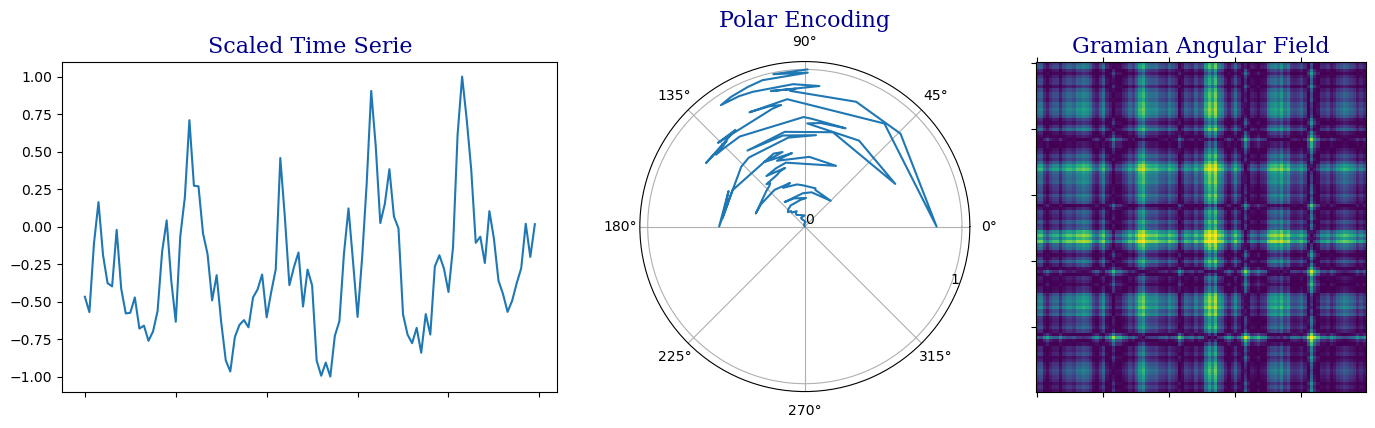

In [100]:
import matplotlib
import matplotlib.pyplot as plt

# GIF
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage



# Jupyter
%matplotlib inline

# Option to write gif
write_gif = False

# Instanciate figure
fig = plt.figure(figsize=(15, 10))

size = 0.33
alignement = 0.1

# Classic plot
ax_carthesian = fig.add_axes([alignement, 0.4, size, size])
# Polar plot
ax_polar = fig.add_axes([alignement + size, 0.4, size, size], polar=True)
# Patchwork
ax_patchwork = fig.add_axes([alignement + 1.8*size, 0.4, size, size])

# Global iteration
iteration = 0

# PLOTS
global size_time_serie
size_time_serie = float(100)

def make_frame(time):
    # Timesteps
    global iteration

    # Data
    t, time_serie = create_time_serie(100, 0)
    gaf, phi, r, scaled_time_serie = gramian_angular_field(eeg)

    # Set to 0 unkown data at time stamp iteration
    #t[iteration:] = 0
    time_serie[iteration:] = 0
    scaled_time_serie[iteration:] = 0
    phi[iteration:] = math.acos(0)
    #r[iteration:] = 0
    gaf[iteration:, iteration:] = 0

    # PLOTS
    font = {
        'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 16,
        }

    # Clear plot
    ax_carthesian.clear()
    ax_polar.clear()
    ax_patchwork.clear()

    # Original Time series
    ax_carthesian.plot(t, scaled_time_serie)
    ax_carthesian.set_title("Scaled Time Serie", fontdict=font)
    ax_carthesian.set_xticklabels([])

    # Polar encoding
    ax_polar.plot(phi, r)
    ax_polar.set_title("Polar Encoding", fontdict=font)
    ax_polar.set_rticks([0, 1])
    ax_polar.set_rlabel_position(-22.5)
    ax_polar.grid(True)

    # Gramian Angular Field
    ax_patchwork.matshow(gaf)
    ax_patchwork.set_title("Gramian Angular Field", fontdict=font)
    ax_patchwork.set_yticklabels([])
    ax_patchwork.set_xticklabels([])

    iteration = iteration + 1

    return mplfig_to_npimage(fig)



# GIF: Write and visualise
animation = VideoClip(make_frame, duration=5)

if(write_gif):
    animation.write_gif("gramian_angulat_field.gif",fps=20)

animation.ipython_display(fps=20, loop=True, autoplay=True)

In [90]:
t = [i for i in range(100)] 

In [98]:
eeg = np.array(next(iter(train_dl))[0][0][4])


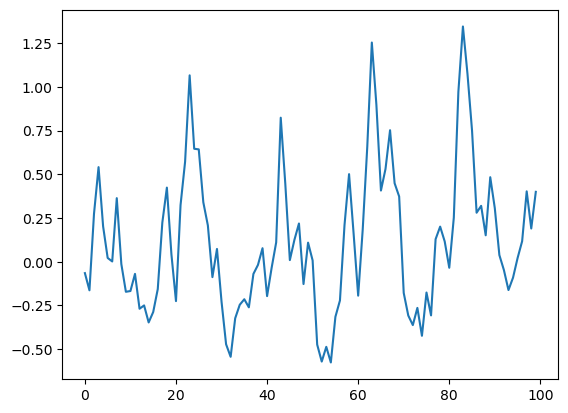

In [99]:
plt.plot(t, eeg)

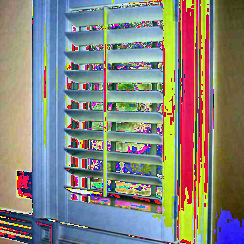

In [97]:
from torchvision.transforms import functional as F


F.to_pil_image(next(iter(train_dl))[1][10])

# To try: Sigmoid instead of tanh

In [10]:
# Regression Model

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(17, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),  # Batch Normalization layer after ReLU
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Batch Normalization layer after ReLU
            nn.MaxPool1d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(128 * 25, 512),  # The size here depends on your input size
            nn.ReLU(),
            nn.BatchNorm1d(512),  # Batch Normalization layer after ReLU

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # Batch Normalization layer after ReLU

            nn.Linear(256, 3 * 244 * 244),
            nn.Tanh()
            # Sigmoid 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = x.view(-1, 3, 244, 244)
        return x


model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    inputs, targets = next(iter(train_dl))
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_dl)
    if epoch % 500 == 0: 
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}")

Epoch [1/10000], Loss: 0.00546
Epoch [501/10000], Loss: 0.00358
Epoch [1001/10000], Loss: 0.00357
Epoch [1501/10000], Loss: 0.00347
Epoch [2001/10000], Loss: 0.00376
Epoch [2501/10000], Loss: 0.00355


KeyboardInterrupt: 

In [11]:
def denormalize(tensor, mean, std):
    tensor_copy = tensor.clone().detach()  # make a copy of the tensor
    for t, m, s in zip(tensor_copy, mean, std):
        t.mul_(s).add_(m)  # denormalize
    return tensor_copy

# Normalization mean and std for ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Denormalize


In [ ]:
d = 8

In [ ]:
from torchvision.transforms import functional as F

target = denormalize(targets[d], mean, std)
F.to_pil_image(target)

In [ ]:
output = denormalize(outputs[d], mean, std)
F.to_pil_image(output)

In [ ]:
test_inputs, test_targets = next(iter(test_dl))
test_inputs = test_inputs.to(device)
test_targets = test_targets.to(device)
test_outputs = model(test_inputs)

In [ ]:
d = 5

In [ ]:


test_target = denormalize(test_targets[d], mean, std)
F.to_pil_image(test_target)

In [ ]:
test_output = denormalize(test_outputs[d], mean, std)
F.to_pil_image(test_output)